# Find good parameter to simulate sequences

In [4]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import generation
import reconstruct_tree
import time
import utils
import pandas as pd
import argparse
import dendropy

def run_method(method, tree, m = 300, kappa = 2, mutation_rate=0.05, threshold = None, verbose = False):
    start_time = time.time()
    observations, taxa_meta = generation.simulate_sequences(m, tree_model=tree, seq_model=generation.Jukes_Cantor(), mutation_rate=mutation_rate, alphabet="DNA")
    runtime = time.time() - start_time
    print("Simulation took %s seconds" % runtime)
    
    if method == "RaXML":
        raxml_HKY = reconstruct_tree.RAxML()
        start_time = time.time()
        tree_rec = raxml_HKY(observations, taxa_meta, raxml_args="-T 2 --HKY85 -c 1")      
    if method == "SNJ":
        snj = reconstruct_tree.SpectralNeighborJoining(reconstruct_tree.JC_similarity_matrix)
        start_time = time.time()
        tree_rec = snj(observations, taxa_meta)
    if method == "NJ":
        nj = reconstruct_tree.NeighborJoining(reconstruct_tree.JC_similarity_matrix)
        start_time = time.time()
        tree_rec = nj(observations, taxa_meta)
    if method == "STR+NJ":
        spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, reconstruct_tree.JC_similarity_matrix)
        start_time = time.time()
        tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.JC_similarity_matrix, 
                                                            taxa_metadata = taxa_meta,
                                                            threshhold = threshold, min_split = 5, verbose = verbose)
    if method == "STR+SNJ":
        spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.SpectralNeighborJoining, reconstruct_tree.JC_similarity_matrix)
        start_time = time.time()
        tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.JC_similarity_matrix, 
                                                            taxa_metadata = taxa_meta, 
                                                            threshhold = threshold, min_split = 5, verbose = verbose)
    if method == "STR+RaXML":
        spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.RAxML, reconstruct_tree.JC_similarity_matrix)
        start_time = time.time()
        tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.JC_similarity_matrix, 
                                                            taxa_metadata = taxa_meta, 
                                                            threshhold = threshold,
                                                            raxml_args = "-T 2 --HKY85 -c 1", min_split = 5, verbose = verbose)
    runtime = time.time() - start_time
    RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)
    print(method)
    if threshold is not None: print(threshold)
    print("--- %s seconds ---" % runtime)
    print("RF = ",RF)
    print("F1% = ",F1) 
    return([method, str(threshold), runtime, RF, F1])

tree = dendropy.Tree.get(path="/gpfs/ysm/project/kleinstein/mw957/data/processed/STDR/steps-128_0.nex", schema="nexus")

In [ ]:
methods = ["RaXML", "SNJ", "NJ", "STR+NJ", "STR+NJ", "STR+SNJ", "STR+SNJ", "STR+RaXML", "STR+RaXML"]
thresholds = [None, None, None, 32, 64, 32, 64, 32, 64]
muts = [0.001, 0.01, 0.1, 0.2, 0.5]
ms = []
ts = []
rts = []
rfs = []
f1s = []

for i in muts:
    for j in range(len(methods)):
        method = methods[j]
        threshold = thresholds[j]
        print(method, threshold)
        res = run_method(method, tree, m = 1000, mutation_rate=i, threshold = threshold)
        ms.append(res[0])
        ts.append(res[1])
        rts.append(res[2])
        rfs.append(res[3])
        f1s.append(res[4])

RaXML None
Simulation took 0.2842717170715332 seconds
RaXML
--- 80.10744404792786 seconds ---
RF =  36
F1% =  92.91338582677164
SNJ None
Simulation took 0.1744709014892578 seconds
SNJ
--- 0.9227867126464844 seconds ---
RF =  76
F1% =  85.03937007874016
NJ None
Simulation took 0.1728808879852295 seconds
NJ
--- 0.41640806198120117 seconds ---
RF =  54
F1% =  89.37007874015748
STR+NJ 32
Simulation took 0.1719040870666504 seconds
STR+NJ
32
--- 0.23844265937805176 seconds ---
RF =  162
F1% =  68.11023622047243
STR+NJ 64
Simulation took 0.17182564735412598 seconds
STR+NJ
64
--- 0.18446087837219238 seconds ---
RF =  132
F1% =  74.01574803149606
STR+SNJ 32
Simulation took 0.17169904708862305 seconds
STR+SNJ
32
--- 0.4059462547302246 seconds ---
RF =  134
F1% =  73.62204724409449
STR+SNJ 64
Simulation took 0.17244839668273926 seconds
STR+SNJ
64
--- 0.3202075958251953 seconds ---
RF =  124
F1% =  75.59055118110236
STR+RaXML 32
Simulation took 0.17229294776916504 seconds
STR+RaXML
32
--- 29.28188

In [ ]:
perf_metrics = pd.DataFrame({'mutation_rate': ms, 'threshold': ts, 'runtime': rts, 'RF': rfs, "F1": f1s})
perf_metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/kim_mutation_rate_128.csv")

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
muts = [0.001, 0.01, 0.1, 0.2, 0.5]

perf_metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/kim_mutation_rate_128.csv")

perf_metrics.loc[:,"mutation_rate"] = list(np.repeat(muts, repeats = 9))

perf_metrics = perf_metrics.loc[:, ["mutation_rate", "method", "threshold", "runtime", "RF", "F1"]]

perf_metrics

has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"

df_long = pd.melt(perf_metrics, id_vars = ["mutation_rate", "method", "threshold"], var_name = "performance")

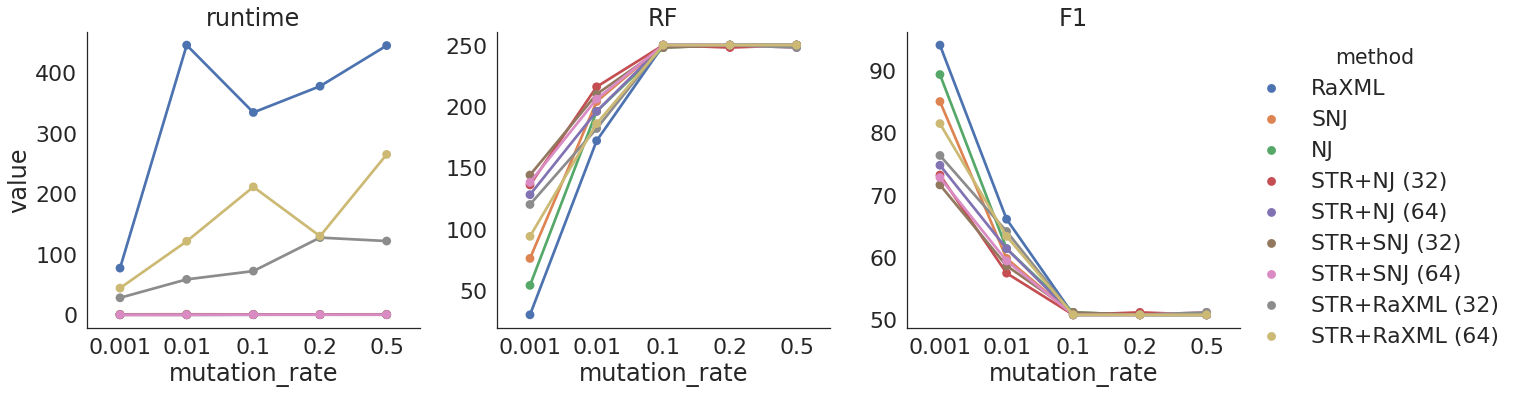

In [27]:
sns.set(style = "white", font_scale = 2)
sns.catplot(data = df_long, x = "mutation_rate", y = "value", hue = "method", 
           col = "performance", legend = True, kind = "point", sharey = False, height = 6).set_titles("{col_name}")

In [46]:
muts =  [0.0005, 0.005]
perf_metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/kim_mutation_rate_128_2.csv")

perf_metrics.loc[:,"mutation_rate"] = list(np.repeat(muts, repeats = 6))

#perf_metrics = perf_metrics.loc[:, ["mutation_rate", "method", "threshold", "runtime", "RF", "F1"]]

perf_metrics = perf_metrics.iloc[:,1:7]

has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"

df_long_2 = pd.melt(perf_metrics, id_vars = ["mutation_rate", "method", "threshold"], var_name = "performance")

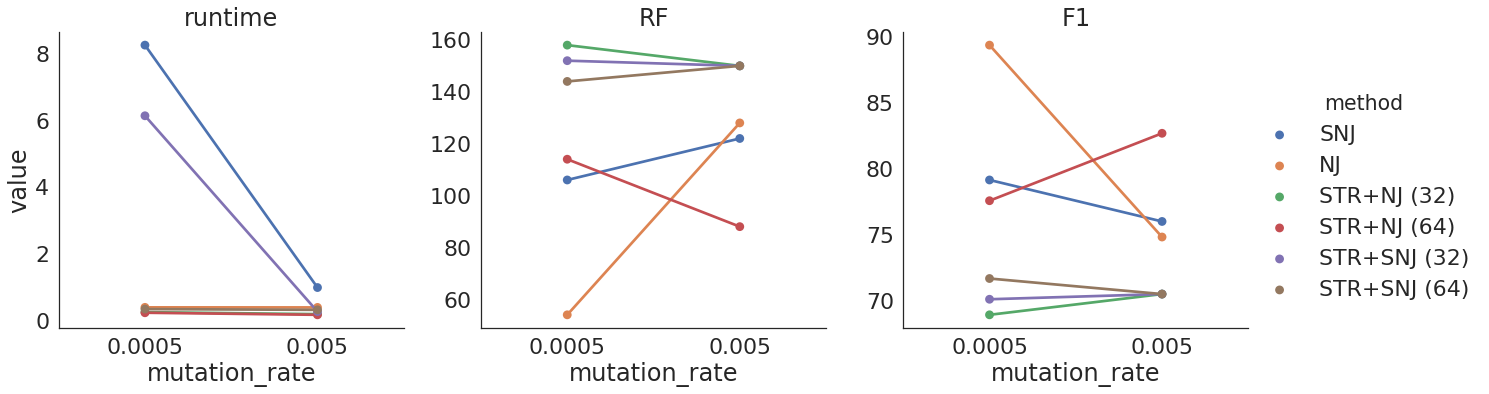

In [48]:
sns.set(style = "white", font_scale = 2)
sns.catplot(data = df_long, x = "mutation_rate", y = "value", hue = "method", 
           col = "performance", legend = True, kind = "point", sharey = False, height = 6).set_titles("{col_name}")